## 0. Introduction
Objectif: Fine-tuner le modèle Logistic Regression en explorant différents hyperparamètres.

Traçabilité et reproductibilité via MLflow.

## 1. Import & configuration

In [77]:
import sys, os
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from rich import print
import shap

# Dataset + constantes
sys.path.insert(0, "..")
from config import PROCESSED_DATA_PATH, TARGET_COL, SEED, FIG_DIR, CV_STRATEGY
from utils import compute_train_test_metrics

df = pd.read_csv(PROCESSED_DATA_PATH)


## Feature engineering

In [78]:
# # Nombre de lignes et colonnes
# print(f"Dataset shape: {df.shape}")

# # Feature engineering : creation difficulty_score = distance * angle
# df["difficulty_score"] = df["distance"] * df["angle"]
# df = df.drop(columns=["angle"])

# # Feature engineering : creation de foot_side_match = ((is_left_footed == 1) & (is_left_side == 1)) | ((is_left_footed == 0) & (is_left_side == 0)
# # Création de la feature foot_side_match : 1 si le pied 'correspond' au côté, 0 sinon
# df["foot_side_match"] = (
#     ((df["is_left_footed"] == 1) & (df["is_left_side"] == 0))
#     | ((df["is_left_footed"] == 0) & (df["is_left_side"] == 1))
# ).astype(int)

# print(df[["is_left_footed", "is_left_side", "foot_side_match"]].head())

# # Nombre de lignes et colonnes
# print(f"Dataset shape after featuring: {df.shape}")

Colonne: is_left_footed, Type: int64

Colonne: game_away, Type: int64

Colonne: is_endgame, Type: int64

Colonne: is_start, Type: int64

Colonne: time_norm, Type: float64

Colonne: distance, Type: int64

Colonne: angle, Type: int64

Colonne: is_left_side, Type: int64

Colonne: has_previous_attempts, Type: int64

Colonne: wind_speed, Type: float64

Colonne: precipitation_probability, Type: float64

Colonne: resultat, Type: int64

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

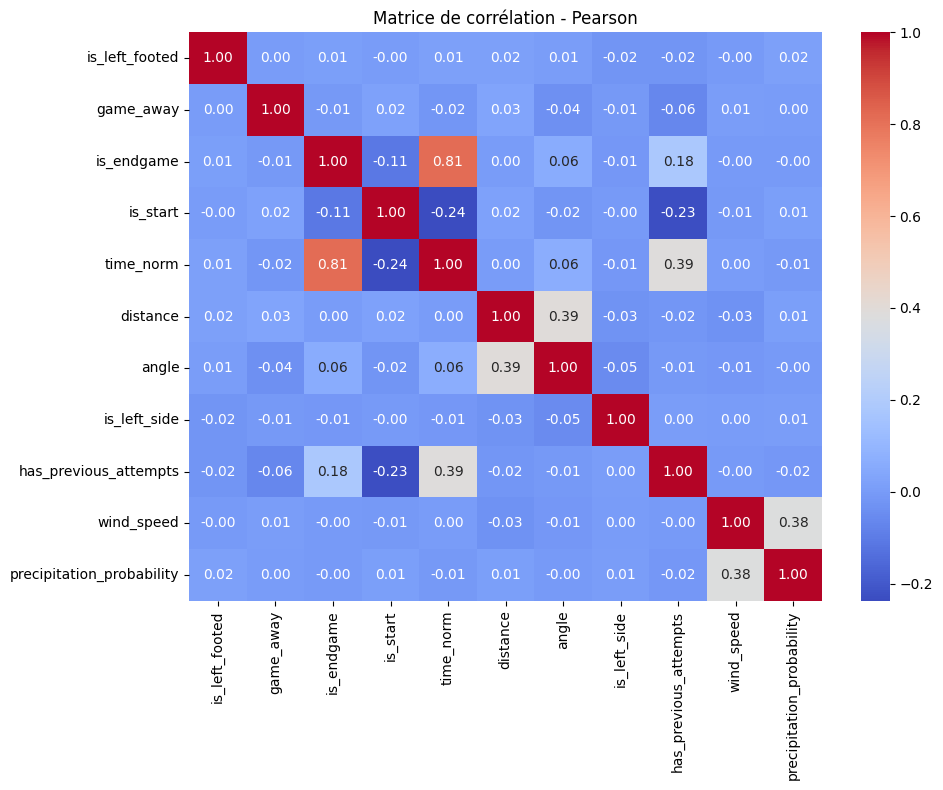

In [79]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in num_cols:
	print(f"Colonne: {col}, Type: {df[col].dtype}")
if TARGET_COL in num_cols:
    num_cols.remove(TARGET_COL)

corr_pearson = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - Pearson")
plt.tight_layout()
plt.show()

## Split Train / test et configuration MLflow

In [80]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# --- Identifier les colonnes numériques et binaires
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns.tolist()
binary_cols = [
    col
    for col in numeric_cols
    if X[col].nunique() == 2
    or (X[col].dtype == "int64" and set(X[col].unique()) == {0, 1})
]
numeric_cols = [col for col in numeric_cols if col not in binary_cols]

NUMERIC_COLS = numeric_cols
BINARY_COLS = binary_cols

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# Configuration MLflow
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Rugby Kicks - LogisticRegression Final Model")
mlflow.set_experiment_tag("author", "Xavier")

# Fin de tout run actif avant de commencer
if mlflow.active_run():
    mlflow.end_run()

# Préparer les datasets
X_trainfull = pd.concat([X_train, y_train], axis=1)
X_testfull = pd.concat([X_test, y_test], axis=1)

train_dataset = mlflow.data.from_pandas(
    X_trainfull, source=PROCESSED_DATA_PATH, name="Training_set"
)
test_dataset = mlflow.data.from_pandas(
    X_testfull, source=PROCESSED_DATA_PATH, name="Test_set"
)

print("[bold green]✅ Configuration prête[/bold green]")

/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/data/processed/kicks_ready_for_model.csv'. Exception: 
  return _dataset_source_registry.resolve(
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:148: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:148: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/xaviercou

✅ Configuration prête

## 2. Preprocessing & Feature Scaling

In [81]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Créer la pipeline de preprocessing
preprocessing_pipeline = ColumnTransformer([
    ('scaler', StandardScaler(), NUMERIC_COLS),
    ('passthrough', 'passthrough', BINARY_COLS)
], remainder='drop')

# FIT sur X_train UNIQUEMENT (prevent data leakage!)
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Convertir en DataFrame pour maintenabilité
feature_names = NUMERIC_COLS + BINARY_COLS
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("[bold green]✅ Pipeline de preprocessing créée et appliquée[/bold green]")
print(f"   - Colonnes numériques standardisées: {NUMERIC_COLS}")
print(f"   - Colonnes binaires conservées: {BINARY_COLS}")
print(f"   - X_train shape: {X_train_processed.shape}")
print(f"   - X_test shape: {X_test_processed.shape}")

✅ Pipeline de preprocessing créée et appliquée

- Colonnes numériques standardisées: ['time_norm', 'distance', 'angle', 'wind_speed', 
'precipitation_probability']

- Colonnes binaires conservées: ['is_left_footed', 'game_away', 'is_endgame', 'is_start', 'is_left_side', 
'has_previous_attempts']

- X_train shape: (13873, 11)

- X_test shape: (3469, 11)

## 3. SMOTE - Synthetic Minority Over-sampling

In [82]:
# --- Appliquer SMOTE pour équilibrer les classes
print("[bold cyan]🔄 Application de SMOTE (Synthetic Minority Over-sampling)...[/bold cyan]")

# Afficher la distribution AVANT SMOTE
print(f"\n[bold]Avant SMOTE:[/bold]")
print(f"  - Classe 0: {(y_train == 0).sum()} samples")
print(f"  - Classe 1: {(y_train == 1).sum()} samples")
print(f"  - Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Appliquer SMOTE
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Afficher la distribution APRÈS SMOTE
print(f"\n[bold]Après SMOTE:[/bold]")
print(f"  - Classe 0: {(y_train_smote == 0).sum()} samples")
print(f"  - Classe 1: {(y_train_smote == 1).sum()} samples")
print(f"  - Ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.2f}:1")

print(f"\n[bold green]✅ SMOTE appliqué avec succès[/bold green]")
print(f"  X_train_smote shape: {X_train_smote.shape}")
print(f"  y_train_smote shape: {y_train_smote.shape}")

🔄 Application de SMOTE (Synthetic Minority Over-sampling)...

Avant SMOTE:

- Classe 0: 3271 samples

- Classe 1: 10602 samples

- Ratio: 0.31:1

Après SMOTE:

- Classe 0: 10602 samples

- Classe 1: 10602 samples

- Ratio: 1.00:1

✅ SMOTE appliqué avec succès

X_train_smote shape: (21204, 11)

y_train_smote shape: (21204,)

## 4. Logistic Regression Fine-tuning with GridSearchCV

In [83]:
# --- Grille de paramètres à explorer (hyperparamètres clés pour LogisticRegression)
# ⚠️  IMPORTANT: éviter les combinaisons invalides
# - lbfgs: supporte UNIQUEMENT l2 ou None
# - liblinear: supporte l1 ou l2
from sklearn.model_selection import ParameterGrid

param_grid = [
    # Solver: lbfgs (uniquement avec penalty l2 ou None)
    {
        "solver": ["lbfgs"],
        "C": [0.1, 0.5, 1.0, 5.0],
        "penalty": ["l2"],
        "max_iter": [1000, 5000],
    },
    # Solver: liblinear (supporte l1 et l2)
    {
        "solver": ["liblinear"],
        "C": [0.1, 0.5, 1.0, 5.0],
        "penalty": ["l1", "l2"],
        "max_iter": [1000, 5000],
    },
]

# Calculer le nombre total de combinaisons
total_combos = sum(len(list(ParameterGrid(grid))) for grid in param_grid)

print("[bold cyan]🔍 Grille de paramètres pour GridSearchCV:[/bold cyan]")
print(f"   Solver lbfgs (penalty=l2): 4 C × 1 penalty × 2 max_iter = 8 combos")
print(f"   Solver liblinear (penalty=l1,l2): 4 C × 2 penalty × 2 max_iter = 16 combos")
print(f"   Total valid combinations: {total_combos}")

🔍 Grille de paramètres pour GridSearchCV:

Solver lbfgs (penalty=l2): 4 C × 1 penalty × 2 max_iter = 8 combos

Solver liblinear (penalty=l1,l2): 4 C × 2 penalty × 2 max_iter = 16 combos

Total valid combinations: 24

## 5. GridSearchCV Execution

In [84]:
with mlflow.start_run(
    run_name="LogisticRegression_Final_Model_SMOTE",
    description="Final LogisticRegression model avec feature engineering + GridSearchCV + SMOTE",
):

    # --- Hyperparamètres de base
    base_params = {
        "random_state": SEED,
        "class_weight": {0: 1, 1: 0.7},
    }

    mlflow.log_input(train_dataset, context="training")
    mlflow.log_input(test_dataset, context="testing")
    mlflow.set_tag("model_type", "logistic_regression_final")
    mlflow.set_tag("optimization_method", "gridsearchcv")
    mlflow.set_tag("resampling", "SMOTE")
    mlflow.set_tag("feature_engineering", "applied")

    # --- Logger les paramètres de base
    mlflow.log_params({f"base_{k}": str(v) for k, v in base_params.items()})

    # --- Logger la grille de paramètres
    mlflow.log_param("grid_config", f"2 parameter groups: lbfgs(l2) + liblinear(l1,l2)")

    # --- Créer le modèle de base
    base_model = LogisticRegression(**base_params)

    # --- Créer GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=CV_STRATEGY,
        scoring="f1_weighted",
        n_jobs=-1,
        verbose=2,
    )

    # --- Entraîner avec GridSearchCV sur les données SMOTE
    print("[bold cyan]🚀 Lancement du GridSearchCV sur données SMOTE...[/bold cyan]")
    grid_search.fit(X_train_smote, y_train_smote)

    # --- Résultats
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_

    print(f"[bold green]✅ GridSearchCV terminé[/bold green]")
    print(f"\n[bold cyan]🏆 Meilleurs paramètres (F1_weighted sur données SMOTE):[/bold cyan]")
    for param, value in best_params.items():
        print(f"   - {param}: {value}")
    print(f"\n   Meilleur score CV (F1_weighted): {best_cv_score:.4f}")

    # --- Logger les meilleurs paramètres
    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_score_f1_weighted_smote", best_cv_score)

    # --- Prédictions finales sur le test set
    y_pred_train = best_model.predict(X_train_processed)
    y_proba_train = best_model.predict_proba(X_train_processed)[:, 1]

    y_pred = best_model.predict(X_test_processed)
    y_proba = best_model.predict_proba(X_test_processed)[:, 1]

    # --- Métriques train/test + overfitting gaps
    final_metrics_test, cm, (fp_rate, fn_rate) = compute_train_test_metrics(
        y_train, y_pred_train, y_proba_train,
        y_test, y_pred, y_proba
    )

    # --- Log metrics
    mlflow.log_metrics(final_metrics_test)

    # --- Log du modèle
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="logreg_final_smote_model",
        input_example=X_test_processed.iloc[:5],
    )

    # --- Matrice de confusion
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title("Confusion Matrix - LogisticRegression Final Model (SMOTE)")
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités terrain")
    plt.tight_layout()
    cm_path = f"{FIG_DIR}/logreg_final_smote_confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close()

    # --- Courbe ROC
    RocCurveDisplay.from_estimator(best_model, X_test_processed, y_test)
    plt.title("ROC Curve - LogisticRegression Final Model (SMOTE)")
    plt.tight_layout()
    roc_path = f"{FIG_DIR}/logreg_final_smote_roc_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)
    plt.close()

    # --- Courbe Precision-Recall avec seuil optimal
    from sklearn.metrics import precision_recall_curve

    # Calculer les courbes precision-recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

    # Trouver le meilleur seuil : maximal precision avec recall >= 0.60
    valid_indices = recall >= 0.60
    if valid_indices.sum() > 0:
        # Parmi les points avec recall >= 0.60, on cherche la meilleure précision
        best_idx = np.argmax(precision[valid_indices])
        # Récupérer l'index réel dans les arrays originaux
        real_idx = np.where(valid_indices)[0][best_idx]
        optimal_threshold = thresholds[real_idx] if real_idx < len(thresholds) else thresholds[-1]
        optimal_precision = precision[real_idx]
        optimal_recall = recall[real_idx]
    else:
        optimal_threshold = 0.5
        optimal_precision = 0
        optimal_recall = 0

    # Créer la courbe Precision-Recall avec le point optimal marqué
    fig, ax = plt.subplots()
    ax.plot(recall, precision, linewidth=2, label="Precision-Recall Curve", color="steelblue")

    # Marquer le point optimal
    ax.plot(optimal_recall, optimal_precision, 'ro', markersize=8, 
            label=f"Optimal (threshold={optimal_threshold:.3f}, recall≥0.60)")
    ax.axvline(x=0.60, color='gray', linestyle='--', alpha=0.7, label="Recall threshold = 0.60")

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Curve - LogisticRegression Final Model (SMOTE)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    pr_path = f"{FIG_DIR}/logreg_final_smote_pr_curve.png"
    plt.savefig(pr_path)
    mlflow.log_artifact(pr_path)
    plt.close()

    # Afficher le résumé du seuil optimal
    print(f"\n[bold magenta]📊 Seuil Optimal (Precision-Recall)[/bold magenta]")
    print(f"  Seuil optimal: {optimal_threshold:.4f}")
    print(f"  Precision @ seuil optimal: {optimal_precision:.4f}")
    print(f"  Recall @ seuil optimal: {optimal_recall:.4f}")
    print(f"  (Contrainte: Recall ≥ 0.60)")

    # --- Feature Importance (Coefficients)
    coef = best_model.coef_[0]
    importances = pd.Series(np.abs(coef), index=X_train_processed.columns).sort_values(ascending=False)
    plt.figure()
    imp_df = pd.DataFrame({'importance': importances[:10].values, 'feature': importances[:10].index})
    sns.barplot(data=imp_df, x='importance', y='feature', palette="coolwarm", hue='feature', legend=False)
    plt.title("Top 10 Feature Importances - LogisticRegression Final Model (SMOTE)")
    plt.tight_layout()
    feat_imp_path = f"{FIG_DIR}/logreg_final_smote_feature_importances.png"
    plt.savefig(feat_imp_path)
    mlflow.log_artifact(feat_imp_path)
    plt.close()

    print("[bold cyan]✅ LogisticRegression Final Model (SMOTE) logué dans MLflow avec succès[/bold cyan]")

    # ========== SHAP Analysis - DANS LE MÊME RUN ==========
    print("\n[bold magenta]🔍 SHAP Analysis - Model Interpretability[/bold magenta]")

    # LinearExplainer pour LogisticRegression (optimisé pour modèles linéaires)
    print("\n[cyan]Computing SHAP values (LinearExplainer for LogisticRegression)...[/cyan]")

    try:
        explainer = shap.LinearExplainer(best_model, X_train_processed)
        shap_values = explainer.shap_values(X_test_processed)

        # Pour classification binaire, shap_values est une liste [class0, class1]
        # On prend class 1 (le cas d'intérêt)
        if isinstance(shap_values, list):
            shap_values_class1 = shap_values[1]
        else:
            shap_values_class1 = shap_values

        # 1️⃣ SUMMARY PLOT - Global Feature Importance
        print("\n[cyan]1. Summary Plot - Feature Importance[/cyan]")
        plt.figure()
        shap.summary_plot(shap_values_class1, X_test_processed, plot_type="bar", show=False)
        plt.title("SHAP Summary Plot (Bar) - LogisticRegression Final Model (SMOTE)")
        plt.tight_layout()
        shap_summary_path = f"{FIG_DIR}/logreg_final_smote_shap_summary_bar.png"
        plt.savefig(shap_summary_path)
        plt.close()
        print(f"   ✅ Saved: {shap_summary_path}")
        mlflow.log_artifact(shap_summary_path)

        # 2️⃣ SUMMARY PLOT (Bee swarm)
        print("\n[cyan]2. Summary Plot (Bee Swarm)[/cyan]")
        plt.figure()
        shap.summary_plot(shap_values_class1, X_test_processed, show=False)
        plt.title("SHAP Summary Plot (Bee Swarm) - LogisticRegression Final Model (SMOTE)")
        plt.tight_layout()
        shap_bee_path = f"{FIG_DIR}/logreg_final_smote_shap_summary_bee.png"
        plt.savefig(shap_bee_path)
        plt.close()
        print(f"   ✅ Saved: {shap_bee_path}")
        mlflow.log_artifact(shap_bee_path)

        # 3️⃣ DEPENDENCE PLOT - Top feature
        print("\n[cyan]3. Dependence Plot - Top Feature[/cyan]")
        top_feature_idx = np.abs(shap_values_class1).mean(axis=0).argsort()[-1]
        top_feature_name = X_test_processed.columns[top_feature_idx]

        plt.figure()
        shap.dependence_plot(top_feature_idx, shap_values_class1, X_test_processed, show=False)
        plt.title(f"SHAP Dependence Plot - {top_feature_name}")
        plt.tight_layout()
        shap_dep_path = f"{FIG_DIR}/logreg_final_smote_shap_dependence_top_feature.png"
        plt.savefig(shap_dep_path)
        plt.close()
        print(f"   ✅ Saved: {shap_dep_path}")
        mlflow.log_artifact(shap_dep_path)

        # 4️⃣ FORCE PLOT - First sample
        print("\n[cyan]4. Force Plot - First Test Sample[/cyan]")
        first_idx = 0
        plt.figure()
        shap.force_plot(explainer.expected_value, shap_values_class1[first_idx], 
                       X_test_processed.iloc[first_idx], matplotlib=True, show=False)
        plt.title(f"SHAP Force Plot - Sample {first_idx} (Actual: {y_test.iloc[first_idx]}, Pred: {y_pred[first_idx]})")
        plt.tight_layout()
        shap_force_path = f"{FIG_DIR}/logreg_final_smote_shap_force_first_sample.png"
        plt.savefig(shap_force_path)
        plt.close()
        print(f"   ✅ Saved: {shap_force_path}")
        mlflow.log_artifact(shap_force_path)

        # 5️⃣ WATERFALL PLOT - First sample
        print("\n[cyan]5. Waterfall Plot - First Test Sample[/cyan]")
        plt.figure()
        shap.waterfall_plot(shap.Explanation(values=shap_values_class1[first_idx], 
                                            base_values=explainer.expected_value,
                                            data=X_test_processed.iloc[first_idx],
                                            feature_names=X_test_processed.columns),
                           show=False)
        plt.title(f"SHAP Waterfall Plot - Sample {first_idx}")
        plt.tight_layout()
        shap_waterfall_path = f"{FIG_DIR}/logreg_final_smote_shap_waterfall_first_sample.png"
        plt.savefig(shap_waterfall_path)
        plt.close()
        print(f"   ✅ Saved: {shap_waterfall_path}")
        mlflow.log_artifact(shap_waterfall_path)

        # 6️⃣ FEATURE IMPORTANCE SUMMARY
        print("\n[cyan]6. SHAP Feature Importance Summary[/cyan]")
        mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
        top_features_shap = pd.Series(mean_abs_shap, index=X_test_processed.columns).sort_values(ascending=False)

        print("\nTop 5 Features by SHAP Impact:")
        for idx, (feature, impact) in enumerate(top_features_shap.head(5).items(), 1):
            print(f"   {idx}. {feature:30s}: {impact:.6f}")

        print("\n[green]✅ SHAP artifacts logged to MLflow in same run![/green]")
        print("\n[bold green]✨ SHAP Analysis Complete![/bold green]")

    except Exception as e:
        print(f"[bold yellow]⚠️  SHAP Analysis skipped: {str(e)}[/bold yellow]")
        print("[cyan]This can happen with certain model configurations. Continuing without SHAP analysis.[/cyan]")

# 🔎 Résumé local
print(
    f"""
📊 Résumé des métriques - LogisticRegression Final Model (SMOTE) :
  Train Accuracy: {final_metrics_test['train_accuracy']:.3f}
  Test Accuracy:  {final_metrics_test['final_test_accuracy']:.3f}
  Overfitting Gap (Accuracy): {final_metrics_test['overfit_gap_accuracy']:.3f}
  ---
  Train F1 classe 0: {final_metrics_test['train_f1_0']:.3f}
  Test F1 classe 0:  {final_metrics_test['final_test_f1_0']:.3f}
  Overfitting Gap (F1_0): {final_metrics_test['overfit_gap_f1_0']:.3f}
  ---
  Accuracy:  {final_metrics_test['final_test_accuracy']:.3f}
  ROC-AUC:   {final_metrics_test['final_test_auc']:.3f}
  Precision classe 0: {final_metrics_test['final_test_precision_0']:.3f}
  Recall classe 0:    {final_metrics_test['final_test_recall_0']:.3f}
  F1-score classe 0:  {final_metrics_test['final_test_f1_0']:.3f}
  Precision classe 1: {final_metrics_test['final_test_precision_1']:.3f}
  Recall classe 1:    {final_metrics_test['final_test_recall_1']:.3f}
  F1-score classe 1:  {final_metrics_test['final_test_f1_1']:.3f}
  FPR:       {fp_rate:.3f}
  FNR:       {fn_rate:.3f}
"""
)

/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🚀 Lancement du GridSearchCV sur données SMOTE...

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .....C=0.1, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.5, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.5, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.5, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.5, max_iter=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.5, max_iter=5000, penalty=l2,

✅ GridSearchCV terminé

🏆 Meilleurs paramètres (F1_weighted sur données SMOTE):

- C: 1.0

- max_iter: 1000

- penalty: l1

- solver: liblinear

Meilleur score CV (F1_weighted): 0.7186

2025/11/15 18:23:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/.venv/lib/python3.12/site-packages/mlflow/ty

📊 Seuil Optimal (Precision-Recall)

Seuil optimal: 0.4886

Precision @ seuil optimal: 0.9375

Recall @ seuil optimal: 0.6002

(Contrainte: Recall ≥ 0.60)

✅ LogisticRegression Final Model (SMOTE) logué dans MLflow avec succès

🔍 SHAP Analysis - Model Interpretability

Computing SHAP values (LinearExplainer for LogisticRegression)...

1. Summary Plot - Feature Importance

✅ Saved: 
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures/logreg_final_smote_shap_summary_bar.png

2. Summary Plot (Bee Swarm)

✅ Saved: 
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures/logreg_final_smote_shap_summary_bee.png

3. Dependence Plot - Top Feature

✅ Saved: 
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures/logreg_final_smote_shap_dependence_top_feature.p
ng

4. Force Plot - First Test Sample

✅ Saved: 
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures/logreg_final_smote_shap_force_first_sample.png

5. Waterfall Plot - First Test Sample

✅ Saved: 
/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures/logreg_final_smote_shap_waterfall_first_sample.p
ng

6. SHAP Feature Importance Summary

Top 5 Features by SHAP Impact:

1. distance                      : 1.197617

2. angle                         : 0.420503

3. is_left_side                  : 0.054179

4. time_norm                     : 0.051555

5. has_previous_attempts         : 0.044487

✅ SHAP artifacts logged to MLflow in same run!

✨ SHAP Analysis Complete!

📊 Résumé des métriques - LogisticRegression Final Model (SMOTE) :
  Train Accuracy: 0.641
  Test Accuracy:  0.659
  Overfitting Gap (Accuracy): -0.018
  ---
  Train F1 classe 0: 0.533
  Test F1 classe 0:  0.548
  Overfitting Gap (F1_0): -0.015
  ---
  Accuracy:  0.659
  ROC-AUC:   0.792
  Precision classe 0: 0.399
  Recall classe 0:    0.877
  F1-score classe 0:  0.548
  Precision classe 1: 0.940
  Recall classe 1:    0.592
  F1-score classe 1:  0.726
  FPR:       0.123
  FNR:       0.408